# Solar Capacity Prediction

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from enum import Enum

from ngboost.scores import LogScore
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from ngboost import NGBRegressor
from sklearn.model_selection import train_test_split
from ngboost.distns import Exponential, Normal, LogNormal

from sklearn.metrics import mean_pinball_loss
from sklearn.metrics import mean_squared_error

from scipy.stats import norm
import ephem
from datetime import datetime

paths = {"era5_eu_2013": "resources/europe-2013-era5.nc",
         "era5_tutorial": "resources/europe-2013-era5-tutorial.nc",
         "offshore_shape": "resources/regions_offshore_elec_s_37.geojson",
         "onshore_shape": "resources/regions_onshore_elec_s_37.geojson",
         "capfacs": "resources/capfacs_37.csv",
         "era5_regions": "resources/europe-2013-era5-regions.nc"}

In [2]:
ds = xr.open_dataset(filename_or_obj=paths["era5_regions"], engine="netcdf4")
ds

<xarray.Dataset>
Dimensions:           (region: 65, time: 8760)
Coordinates:
  * region            (region) object 'AL0 0 on' 'AT0 0 on' ... 'SI0 0 off'
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
Data variables:
    height            (region, time) float64 ...
    wnd100m           (region, time) float64 ...
    roughness         (region, time) float64 ...
    influx_toa        (region, time) float64 ...
    influx_direct     (region, time) float64 ...
    influx_diffuse    (region, time) float64 ...
    albedo            (region, time) float64 ...
    temperature       (region, time) float64 ...
    soil_temperature  (region, time) float64 ...
    runoff            (region, time) float64 ...
Attributes:
    description:  Era5 data with mean value of the coordinates within a region

In [3]:
gdf_onshore = gpd.read_file(paths["onshore_shape"])
gdf_onshore["centroid"] = gdf_onshore.centroid
gdf_onshore["centroid_cea"] = gdf_onshore.to_crs('+proj=cea').centroid.to_crs(gdf_onshore.crs)
gdf_onshore

C:\Users\Thomas\AppData\Local\Temp/ipykernel_9632/3403543981.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_onshore["centroid"] = gdf_onshore.centroid


,name,geometry,centroid,centroid_cea
0,AL0 0,"POLYGON ((20.32207 39.91318, 20.39703 39.81809...",POINT (20.05340 41.14346),POINT (20.05440 41.13135)
1,AT0 0,"POLYGON ((14.94402 46.83544, 15.00447 46.63686...",POINT (14.05979 47.61864),POINT (14.05050 47.60873)
2,BA0 0,"POLYGON ((17.62996 45.15735, 17.68474 45.16396...",POINT (17.77465 44.17092),POINT (17.77765 44.16141)
3,BE0 0,"POLYGON ((5.71028 49.53109, 5.67555 49.53781, ...",POINT (4.64535 50.66274),POINT (4.64920 50.65686)
4,BG0 0,"POLYGON ((24.00074 41.46414, 23.94989 41.43758...",POINT (25.21863 42.76890),POINT (25.21550 42.75680)
5,CH0 0,"POLYGON ((6.85093 46.04965, 6.84855 46.08504, ...",POINT (8.23767 46.78605),POINT (8.23665 46.78096)
6,CZ0 0,"POLYGON ((16.91052 48.63078, 16.89667 48.69698...",POINT (15.31332 49.73206),POINT (15.31683 49.72325)
7,DE0 0,"MULTIPOLYGON (((8.45827 47.63988, 8.51493 47.6...",POINT (10.38515 51.09781),POINT (10.37491 50.98691)
8,DK0 0,"MULTIPOLYGON (((9.61036 54.90323, 9.62993 54.9...",POINT (9.46290 56.14451),POINT (9.46096 56.12621)
9,DK4 0,"POLYGON ((11.71762 55.92084, 11.66310 55.90717...",POINT (11.87510 55.52008),POINT (11.87453 55.51622)


<AxesSubplot:>

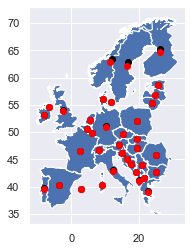

In [5]:
ax = gdf_onshore["geometry"].plot()
gdf_onshore["centroid"].plot(ax=ax, color="black")
gdf_onshore["centroid_cea"].plot(ax=ax, color="red")

In [6]:
gdf_offshore = gpd.read_file(paths["offshore_shape"])
gdf_offshore["centroid"] = gdf_offshore.centroid
gdf_offshore["centroid_cea"] = gdf_offshore.to_crs('+proj=cea').centroid.to_crs(gdf_offshore.crs)
gdf_offshore

C:\Users\Thomas\AppData\Local\Temp/ipykernel_9632/2253025528.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_offshore["centroid"] = gdf_offshore.centroid


,name,geometry,centroid,centroid_cea
0,AL0 0,"POLYGON ((19.98542 39.69475, 20.01003 39.69120...",POINT (19.15033 40.86663),POINT (19.15085 40.86124)
1,BE0 0,"POLYGON ((3.25367 51.34858, 3.10403 51.31485, ...",POINT (2.69824 51.46870),POINT (2.69837 51.46773)
2,BG0 0,"POLYGON ((29.34583 42.24111, 28.32389 41.99778...",POINT (29.21609 42.94220),POINT (29.21340 42.93782)
3,DE0 0,"MULTIPOLYGON (((14.22389 53.70083, 13.95916 53...",POINT (8.40159 54.55749),POINT (8.41169 54.54890)
4,DK0 0,"POLYGON ((9.99277 55.70499, 10.04583 55.75027,...",POINT (8.02640 56.40582),POINT (8.01237 56.38103)
5,DK4 0,"MULTIPOLYGON (((12.93400 54.83381, 12.74997 54...",POINT (13.23751 55.27354),POINT (13.24303 55.26481)
6,EE6 0,"POLYGON ((23.72555 58.74471, 23.53527 58.74180...",POINT (22.99179 58.76941),POINT (22.97433 58.75252)
7,ES0 0,"MULTIPOLYGON (((-5.36028 35.91625, -5.39555 35...",POINT (-6.04177 42.16895),POINT (-5.91818 41.97233)
8,ES2 0,"POLYGON ((1.87083 37.64028, 1.73314 37.62605, ...",POINT (3.76614 39.46761),POINT (3.76150 39.45377)
9,FI4 0,"MULTIPOLYGON (((23.43159 59.95382, 23.56135 59...",POINT (27.76650 68.94839),POINT (26.82149 67.07108)


In [58]:
def is_daytime(time: datetime, lat: str, lon: str) -> bool:
    obs = ephem.Observer()
    obs.date = time
    obs.lat = str(lat)
    obs.lon = str(lon)

    print("UTC date: ", time)

    next_sunrise = obs.next_rising(ephem.Sun())
    print("Next sunrise:", next_sunrise)
    next_sunset = obs.next_setting(ephem.Sun())
    print("Next sunset:", next_sunset)

    if next_sunset < next_sunrise:
        print("It is daytime: ", time)
        return True
    else:
        print("It is nighttime: ", time)
        return False


time = datetime.utcnow()
lon = gdf_onshore.iloc[[7]]["centroid_cea"].x.values[0]
lat = gdf_onshore.iloc[[7]]["centroid_cea"].y.values[0]
print(lon)
print(lat)
is_daytime(time, lat, lon)

10.374912125515754
50.9869070357543
UTC date:  2022-06-24 07:28:17.190715
Next sunrise: 2022/6/25 03:04:46
Next sunset: 2022/6/24 19:37:26
It is daytime:  2022-06-24 07:28:17.190715


True

In [66]:
# Dimension/Coordinates sizes
N_time = ds.dims['time']
N_regions = ds.dims['region']

# Initial data variables with 0
is_day = np.full((N_regions, N_time), True)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [29]:
capfacts = pd.read_csv(paths["capfacs"])
capfacts

,snapshot,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 ror,AT0 0 solar,BA0 0 onwind,BA0 0 solar,BE0 0 offwind-ac,...,SE4 0 onwind,SE4 0 ror,SE4 0 solar,SI0 0 offwind-ac,SI0 0 onwind,SI0 0 ror,SI0 0 solar,SK0 0 onwind,SK0 0 ror,SK0 0 solar
0,2013-01-01 00:00:00,0.003291,0.001469,0.0,0.163262,0.224456,0.0,0.007340,0.0,1.000000,...,0.459609,0.626955,0.0,0.000000,0.055146,0.344668,0.0,0.361009,0.106197,0.0
1,2013-01-01 01:00:00,0.002103,0.000000,0.0,0.171340,0.224369,0.0,0.007939,0.0,0.999998,...,0.463265,0.625502,0.0,0.000000,0.052605,0.344657,0.0,0.368912,0.106012,0.0
2,2013-01-01 02:00:00,0.000000,0.000000,0.0,0.171035,0.224300,0.0,0.007829,0.0,0.993941,...,0.463777,0.624810,0.0,0.000000,0.052222,0.344593,0.0,0.382949,0.105968,0.0
3,2013-01-01 03:00:00,0.000000,0.000000,0.0,0.169685,0.224249,0.0,0.005766,0.0,0.916094,...,0.463041,0.623794,0.0,0.000000,0.050762,0.344626,0.0,0.388344,0.106215,0.0
4,2013-01-01 04:00:00,0.000000,0.000000,0.0,0.159757,0.224213,0.0,0.004262,0.0,0.704786,...,0.457253,0.623085,0.0,0.000000,0.047285,0.344607,0.0,0.409303,0.106364,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2013-12-31 19:00:00,0.029235,0.024321,0.0,0.109127,0.275353,0.0,0.001076,0.0,0.998922,...,0.358191,0.469586,0.0,0.027877,0.001708,0.696975,0.0,0.125735,0.157729,0.0
8756,2013-12-31 20:00:00,0.034024,0.031357,0.0,0.120485,0.275159,0.0,0.001090,0.0,0.965757,...,0.324709,0.469395,0.0,0.023567,0.000000,0.696262,0.0,0.142431,0.157817,0.0
8757,2013-12-31 21:00:00,0.037104,0.034522,0.0,0.128186,0.274975,0.0,0.001062,0.0,0.852484,...,0.288415,0.469208,0.0,0.000000,0.004891,0.695524,0.0,0.153930,0.157899,0.0
8758,2013-12-31 22:00:00,0.029730,0.027419,0.0,0.124740,0.274784,0.0,0.001351,0.0,0.776442,...,0.268695,0.469028,0.0,0.000000,0.009091,0.694665,0.0,0.163442,0.157945,0.0


In [35]:
class EnergyType(Enum):
    """
    Represents the different type of renewable energy sources in pypsa-eur
    """
    OFFWIND_AC = "offwind-ac"
    OFFWIND_DC = "offwind-dc"
    ONWIND = "onwind-dc"
    SOLAR = "solar"
    ROR = "ror"
    NOT_DEFINED = "not_defined"

class Feature(Enum):
    """
    Represents the features, that can be extracted from the era-5 weather data set
    """
    HEIGHT = "height"
    WND100M = "wnd100m"
    ROUGHNESS = "roughness"
    INFLUX_TOA = "influx_toa"
    INFLUX_DIRECT = "influx_direct"
    INFLUX_DIFFUSE = "influx_diffuse"
    ALBEDO = "albedo"
    TEMPERATURE = "temperature"
    SOIL_TEMPERATURE = "soil_temperature"
    RUNOFF = "runoff"

"""
Determines which features are selected to calculate the capacity factor of a certain energy type.
"""
feature_set = {
    EnergyType.OFFWIND_AC: [Feature.HEIGHT, Feature.WND100M, Feature.ROUGHNESS],
    EnergyType.OFFWIND_DC: [Feature.HEIGHT, Feature.WND100M, Feature.ROUGHNESS],
    EnergyType.ONWIND: [Feature.HEIGHT, Feature.WND100M, Feature.ROUGHNESS],
    EnergyType.SOLAR: [Feature.INFLUX_TOA, Feature.INFLUX_DIRECT, Feature.INFLUX_DIFFUSE, Feature.TEMPERATURE],
    EnergyType.ROR: []
}

def find_countries_in_capfacts(country_name="") -> list:
    """
    Returns the full region names and energy types of the given name abbreviation that can be found in the .csv file with capacity factors.
    :param country_name: Two character abbreviation of the searched country
    :return: list of all regions and energy types to the given country name
    """
    countries = []
    for column in capfacts:
        if column.find(country_name) >= 0:
            countries.append(column)
    return countries


def get_energy_type(name: str) -> EnergyType:
    """
    Returns the energy type for a given string
    :param name: energy type as string
    :return: energy type for the given string
    """
    match name:
        case "offwind-ac":
            return EnergyType.OFFWIND_AC
        case "offwind-dc":
            return EnergyType.OFFWIND_DC
        case "onwind":
            return EnergyType.ONWIND
        case "solar":
            return EnergyType.SOLAR
        case "ror":
            return EnergyType.ROR
        case _:
            return EnergyType.NOT_DEFINED

def get_ds_region_name(region_name: str, energy_type: EnergyType) -> str:
    """
    Returns the name or string that addresses the given region and energy type which can be used to address the data in the feature data set
    :param region_name: name of the region
    :param energy_type: the uses energy type in that region
    :return: string that can be used to fetch data from the feature data set
    """
    ds_region_name = region_name + " 0"
    if energy_type == EnergyType.ONWIND or energy_type == EnergyType.SOLAR or energy_type == EnergyType.ROR:
        ds_region_name += " on"
    elif energy_type == EnergyType.OFFWIND_AC or energy_type == EnergyType.OFFWIND_DC:
        ds_region_name += " off"
    else:
        ds_region_name += ""
    return ds_region_name

def parse_capfac_col(column_name: str) -> (str, EnergyType):
    """
    Returns a tuple of the region name and energy type for a given column name of the capfacts .csv file
    :param column_name: column name of the capfacts .csv file
    :return: Tuple of a region name and energy type, None if no region is found
    """
    col_args = column_name.split(" ")
    if len(col_args) == 3:
        region_name = col_args[0]
        energy_type = get_energy_type(col_args[2])
        return region_name, energy_type
    return None, None

def create_training_data_for_col(column_name: str) -> (np.ndarray, dict):
    """
    Creates and returns the the training data set with the relevant data for a given column name from the capfacts .csv file.
    The training data set is a tuple of a numpy array of capacity factors (target values) and a dictionary of the era5 data (feature data),
    :param column_name: column name of the capfacts .csv file
    :return: Tuple of capacity factor (Y) and trainings data (X)
            X                       : DataFrame object or List or numpy array of predictors (n x p) in Numeric format
            Y                       : DataFrame object or List or numpy array of outcomes (n) in Numeric format.
    """
    region_name, energy_type = parse_capfac_col(column_name)
    # print(region_name)
    # print(energy_type)
    ds_region_name = get_ds_region_name(region_name, energy_type)
    # print(ds_region_name)
    features = feature_set.get(energy_type)
    # print(features)

    Y_capfac = capfacts[column_name].values
    X = {}
    for feature in features:
        X[feature] = ds.sel(region=ds_region_name)[feature.value].values

    return Y_capfac, X


def shape_multi_feature_data(training_data: dict):
    """
    Reshapes the trainingsdata in an array of shape (n_samples, n_features)
    (8760, 2) ---> [[x_f1_1, x_f2_1], [x_f1_2, x_f2_2], ... , [x_f1_8760, x_f2_8760]]
    :param training_data as a dictinary of multiple 1-d arrays:
    :return: trainingsdata in array of shape (n_samples, n_features)
    """
    # tup = tuple(list(training_data.values()))
    # multi_feature_train_data = np.column_stack(tup)
    arrays = list(training_data.values())
    return np.stack(arrays, axis=-1)


In [46]:
Y, X = create_training_data_for_col("DE0 0 solar")
X_train, X_test, Y_train, Y_test = train_test_split(shape_multi_feature_data(X), Y, test_size=0.25)

ngb = NGBRegressor().fit(X_train, Y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

[iter 0] loss=-0.5424 val_loss=0.0000 scale=1.0000 norm=0.5639
[iter 100] loss=-1.5544 val_loss=0.0000 scale=2.0000 norm=0.8639
[iter 200] loss=-2.2248 val_loss=0.0000 scale=2.0000 norm=0.9214
[iter 300] loss=-2.9176 val_loss=0.0000 scale=2.0000 norm=0.9042
[iter 400] loss=-3.2129 val_loss=0.0000 scale=2.0000 norm=0.8247


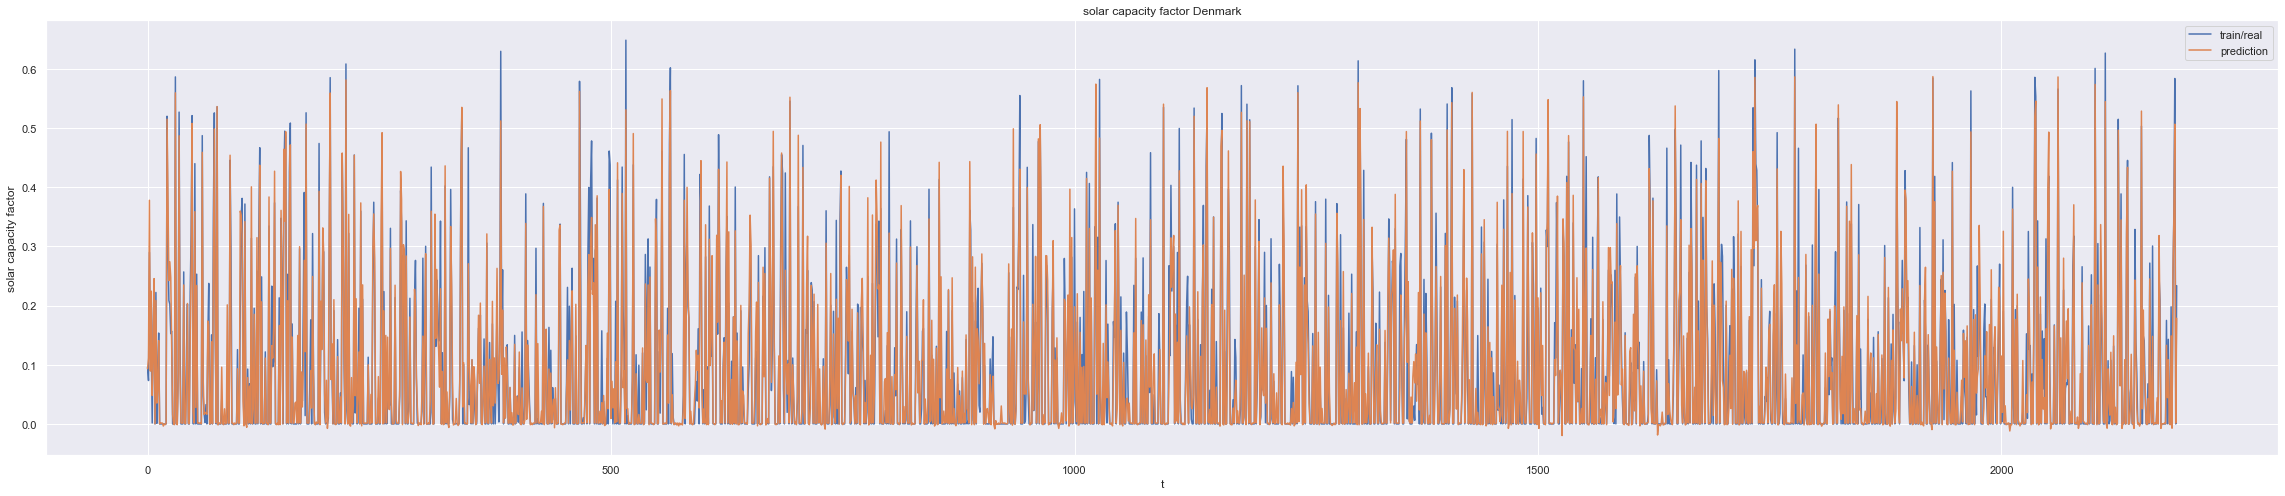

In [48]:
plt.figure(figsize=(40,8))
plt.plot(Y_test, label="train/real")
plt.plot(Y_preds, label="prediction")
plt.xlabel("t")
plt.ylabel("solar capacity factor")
plt.title("solar capacity factor Denmark")
plt.legend()

Text(0.5, 1.0, 'solar capacity factor difference Denmark')

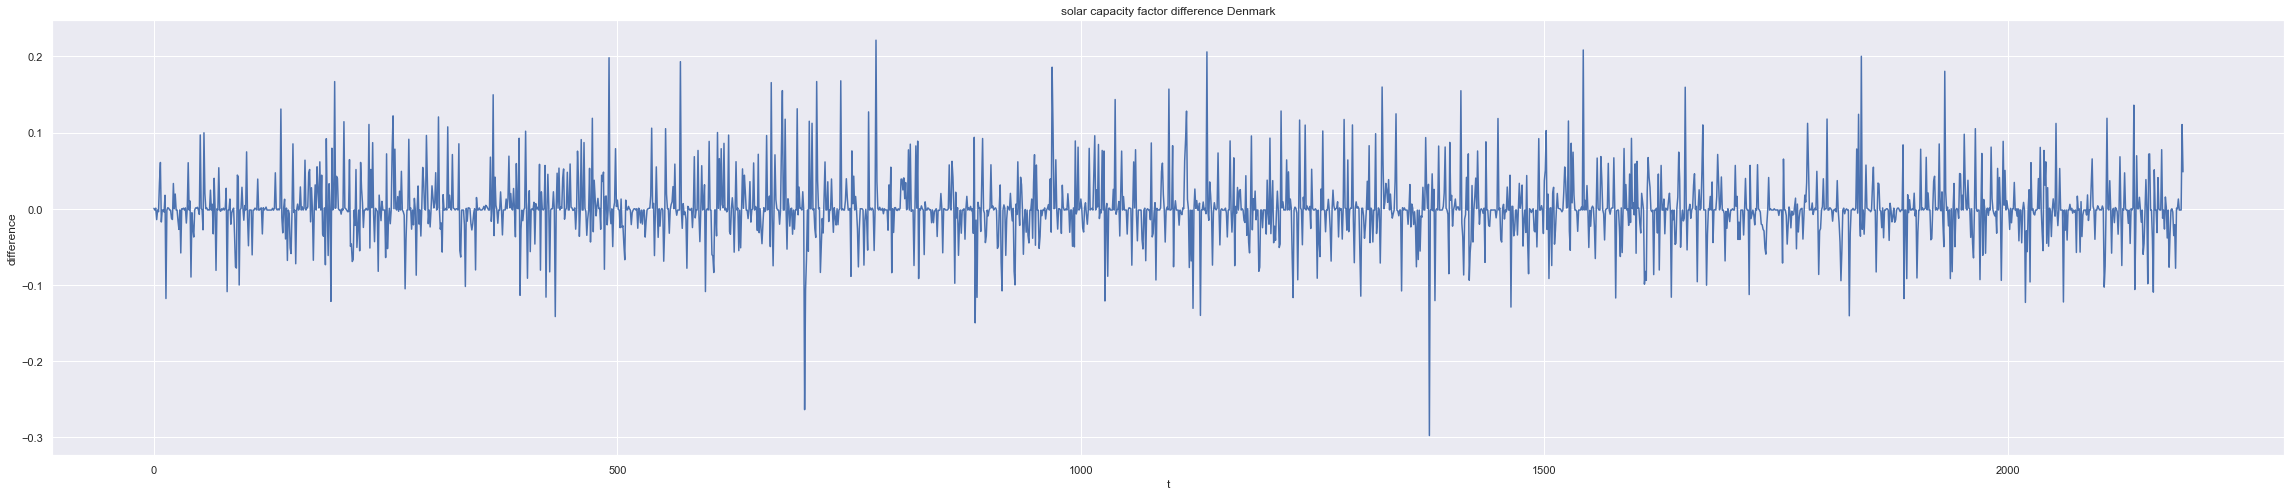

In [39]:
prediction_diff = Y_test - Y_preds

plt.figure(figsize=(40,8))
plt.plot(prediction_diff)
plt.xlabel("t")
plt.ylabel("difference")
plt.title("solar capacity factor difference Denmark")

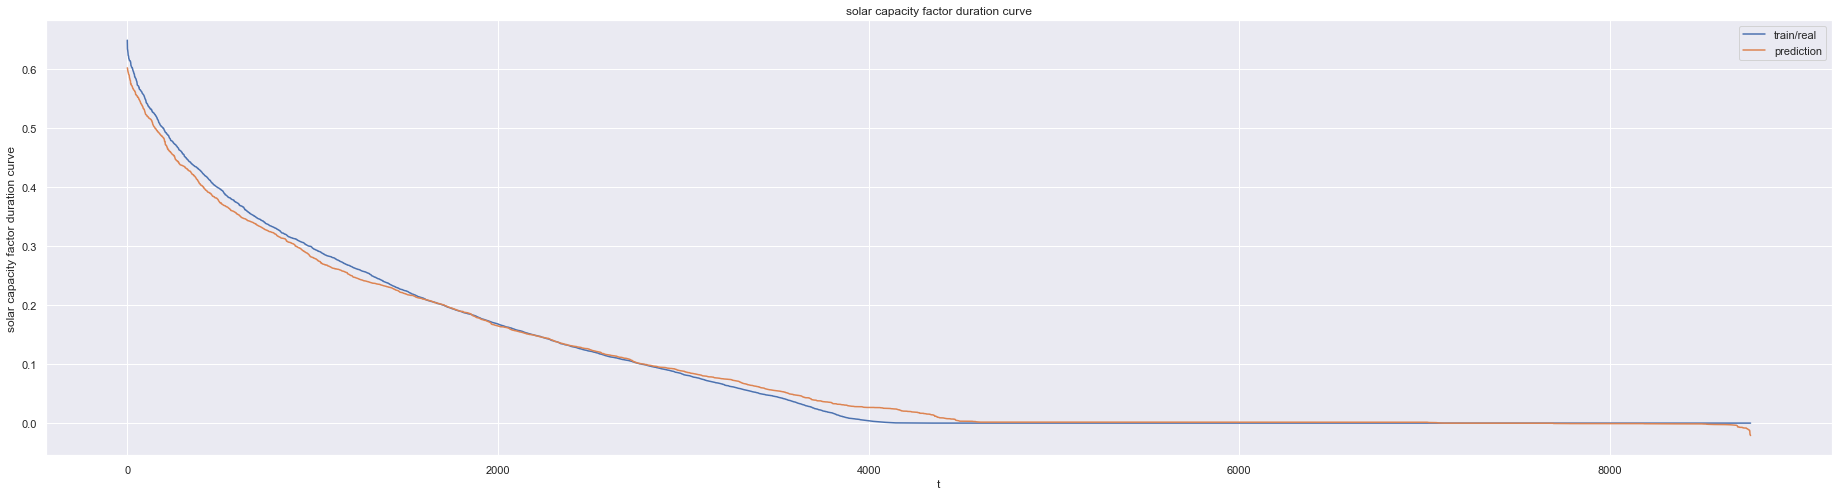

In [36]:
Y_preds_duration_curve = np.sort(Y_preds)[::-1]
Y_test_duration_curve = np.sort(Y_test)[::-1]

plt.figure(figsize=(32,8))
plt.plot(Y_test_duration_curve, label="test/real")
plt.plot(Y_preds_duration_curve, label="prediction")
plt.xlabel("t")
plt.ylabel("solar capacity factor duration curve")
plt.title("solar capacity factor duration curve Denmark")
plt.legend()

In [42]:
print(feature_set.get(EnergyType.SOLAR))
## Feature importance for loc trees
feature_importance_loc = ngb.feature_importances_[0]
print(feature_importance_loc)

## Feature importance for scale trees
feature_importance_scale = ngb.feature_importances_[1]
print(feature_importance_scale)

[<Feature.INFLUX_TOA: 'influx_toa'>, <Feature.INFLUX_DIRECT: 'influx_direct'>, <Feature.INFLUX_DIFFUSE: 'influx_diffuse'>, <Feature.TEMPERATURE: 'temperature'>]
[0.18221065 0.43203755 0.17464432 0.21110749]
[0.35307664 0.40658435 0.17842221 0.06191681]


In [43]:
def coverage_fraction(y, y_low, y_high):
    """
    :param y:
    :param y_low:
    :param y_high:
    :return:
    """
    return np.mean(np.logical_and(y >= y_low, y <= y_high))

# 80% confidence intervall
Y_preds_q10 = Y_dists.ppf(0.1)
Y_preds_q90 = Y_dists.ppf(0.9)
print(coverage_fraction(Y_test, Y_preds_q10, Y_preds_q90))

# 90% confidence intervall
Y_preds_q05 = Y_dists.ppf(0.05)
Y_preds_q95 = Y_dists.ppf(0.95)
print(coverage_fraction(Y_test, Y_preds_q05, Y_preds_q95))

0.8803652968036529
0.9351598173515981


In [44]:
# Y_preds_q50 = Y_preds (point prediction)
Y_preds_q50 = Y_dists.ppf(0.5)
print("MSE: " , mean_squared_error(Y_test, Y_preds))

# Pinball loss for q=0.4
Y_preds_q40 = Y_dists.ppf(0.4)
print("PL q=0.4:", mean_pinball_loss(Y_test, Y_preds_q40, alpha=0.4))

# Pinball loss for q=0.6
Y_preds_q60 = Y_dists.ppf(0.6)
print("PL q=0.6: ", mean_pinball_loss(Y_test, Y_preds_q40, alpha=0.6))

MSE:  0.0017408714867290988
PL q=0.4: 0.011180203583247773
PL q=0.6:  0.012591446496468253
